In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
import random

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


## For this project we are using a model-based methodology for Image Segmentation

### A metrica que utilizaremos pra treinar o nosso modelo eh a Intersection-Over-Union

Essa metrica consiste em calcular a area de sobreposição entre a segmentação prevista e a mascara dividido pela area de união entre a segmentação prevista e a mascara

In [2]:
from keras import backend as K

##Metrica
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
    return iou
##Loss Function
#def iou_coef_loss(y_true, y_pred):
#    return -iou_coef(y_true, y_pred)
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

### Formando os arrays de imagens e mascaras

In [3]:
directory = os.fsencode("./new_maps")

images = []
titulos = []

list_directory = os.listdir(directory.decode("utf-8"))

list_directory.sort()
    
for file in list_directory:
    filename = os.fsdecode(file)
    titulos.append(filename)
    filename_path = directory.decode("utf-8") + "/" + filename
    img = imageio.imread(filename_path)
    images.append(img)
    
directory = os.fsencode("./new_masks")

masks = []
titulos = []

list_directory = os.listdir(directory.decode("utf-8"))

list_directory.sort()
    
for file in list_directory:
    filename = os.fsdecode(file)
    titulos.append(filename)
    filename_path = directory.decode("utf-8") + "/" + filename
    img = imageio.imread(filename_path)
    masks.append(img)
    
masks = np.array(masks)
images = np.array(images)

masks = np.expand_dims(masks, -1)

### Splitando os dados entre treino e teste

In [4]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2)

### Criando o modelo

In [5]:
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.layers import BatchNormalization
import keras

In [6]:
def get_unet(input_img, dropout = 0.1):

    #Contração
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (input_img)
    c1 = BatchNormalization() (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    c1 = BatchNormalization() (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout)(p1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = BatchNormalization() (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    c2 = BatchNormalization() (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = BatchNormalization() (c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    c3 = BatchNormalization() (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = BatchNormalization() (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    c4 = BatchNormalization() (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = BatchNormalization() (c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
    c5 = BatchNormalization() (c5)

    #Expansão
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = BatchNormalization() (c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
    c6 = BatchNormalization() (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = BatchNormalization() (c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
    c7 = BatchNormalization() (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = BatchNormalization() (c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
    c8 = BatchNormalization() (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = BatchNormalization() (c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
    c9 = BatchNormalization() (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [7]:
input_img = Input((256,256,3))
model = get_unet(input_img, dropout=0.05)
model.compile(
        optimizer= Adam(),
        loss= "binary_crossentropy",
        #metrics=["accuracy"])
        #loss=soft_dice_loss,
        metrics=[iou_coef])
history = model.fit(train_images,
                    train_masks/255,
                    validation_split = 0.1,
                    batch_size = 16,
                    validation_data = (test_images,test_masks),
                    epochs=30)

Epoch 1/30
31/31 [==============================] - 221s 7s/step - loss: 0.6843 - iou_coef: 0.0221 - val_loss: 11.8134 - val_iou_coef: 0.0251
Epoch 2/30
31/31 [==============================] - 214s 7s/step - loss: 0.5732 - iou_coef: 0.0262 - val_loss: 0.5019 - val_iou_coef: 0.0200
Epoch 3/30
31/31 [==============================] - 214s 7s/step - loss: 0.4859 - iou_coef: 0.0316 - val_loss: 0.5415 - val_iou_coef: 0.0339
Epoch 4/30
31/31 [==============================] - 214s 7s/step - loss: 0.3997 - iou_coef: 0.0358 - val_loss: 0.3617 - val_iou_coef: 0.0411
Epoch 5/30
31/31 [==============================] - 212s 7s/step - loss: 0.3172 - iou_coef: 0.0413 - val_loss: 0.2780 - val_iou_coef: 0.0287
Epoch 6/30
31/31 [==============================] - 210s 7s/step - loss: 0.2552 - iou_coef: 0.0441 - val_loss: 0.2986 - val_iou_coef: 0.0388
Epoch 7/30
31/31 [==============================] - 204s 7s/step - loss: 0.2013 - iou_coef: 0.0526 - val_loss: 0.1889 - val_iou_coef: 0.0696
Epoch 8/30
3

In [8]:
model.evaluate(test_images, test_masks)

5/5 [==============================] - 9s 2s/step - loss: -21.7852 - iou_coef: 0.9207


[-21.785173416137695, 0.9206935167312622]

In [9]:
predictions = model.predict(test_images, verbose=1)

5/5 [==============================] - 9s 2s/step


In [10]:
def normalization(img):
    m = img.min()
    M = img.max()
    print(m)
    print(M)
    return ((img-m)/(M-m))*1
def threshold(img):
    n = img.shape[0]
    m = img.shape[1]
    counter = 0
    for x in range (n):
        for y in range(m):
            if img[x,y] < img.mean():
                img[x,y] = 0
            else:
                img[x,y] = 255
                counter+=1
    return counter

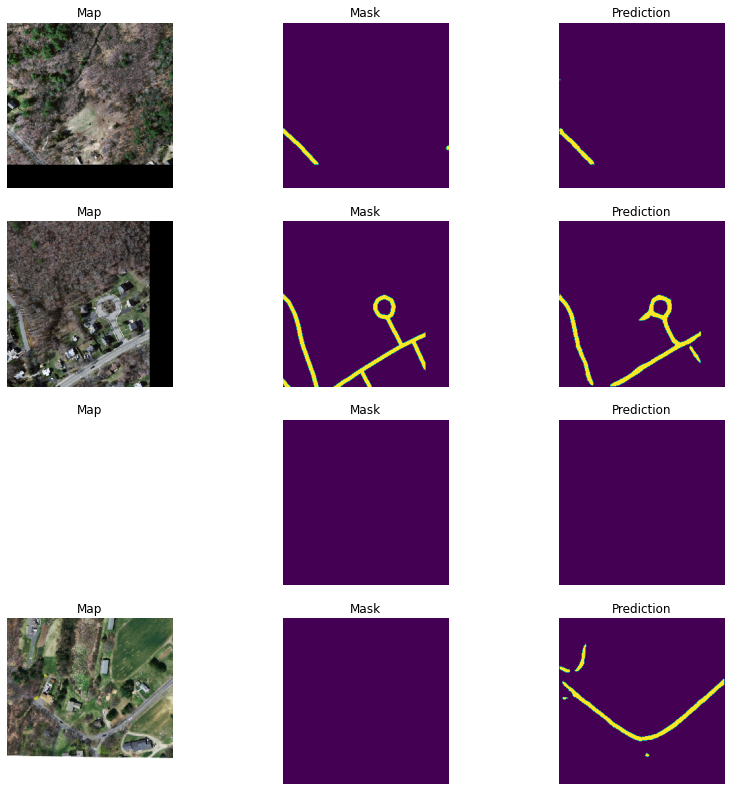

In [15]:
f = plt.figure(figsize=(14,14))
pred = (predictions > 0.5).astype(np.uint8)
for i in range(0,12,3):
    
    j = random.randint(1,137)
    f.add_subplot(4, 3, i+1)
    plt.imshow(test_images[j])
    plt.title("Map")
    plt.axis('off')

    f.add_subplot(4, 3, i+2)
    plt.imshow(np.squeeze(test_masks[j]))
    plt.title("Mask")
    plt.axis('off')

    f.add_subplot(4, 3, i+3)
    plt.imshow(np.squeeze(pred[j]))
    plt.title("Prediction")
    plt.axis('off')

plt.show()

In [12]:
model.save('my_model.h5') 

### Observacoes:

#### Devido ao dataset extremamente reduzido (somente 36 imagens para elaborar um esboco do projeto) e a arquitetura nada otimizada da CNN, os outputs gerados pelo modelo tem um resultado muito abaixo do esperado,

TypeError: Invalid shape (256, 256, 1) for image data

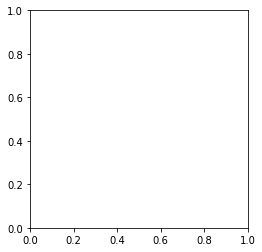

In [13]:
plt.imshow(masks[0])